# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

X_coords, X_sizes = train['coords'], train['sizes']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
import csv

# Number of training examples
n_train = len(train['labels'])

# Number of testing examples.
n_test = len(test['labels'])

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
labelmap = {}
with open('./signnames.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        labelmap[int(row['ClassId'])] = row['SignName']
n_classes = len(labelmap)
        
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Description: Speed limit (30km/h)
Original image size:
[42 43]
Original image bounding box (x1, y1, x2, y2):
[ 6  5 37 38]


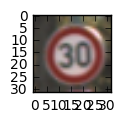

In [3]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random

index = random.randint(0, n_train)
image = X_train[index]

plt.figure(figsize=(1,1))
plt.imshow(image)
print("Description: " + labelmap[y_train[index]])
print("Original image size:")
print(X_sizes[index])
print("Original image bounding box (x1, y1, x2, y2):")
print(X_coords[index])


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

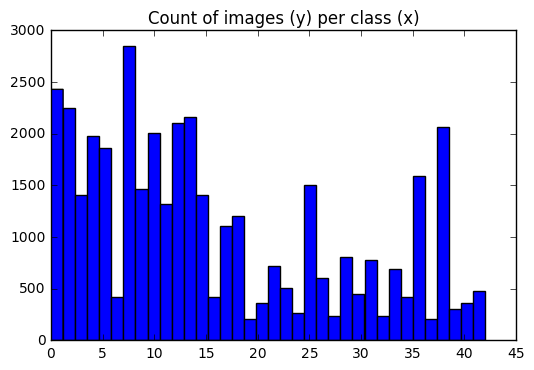

In [4]:
# Pre-processing of the data

import numpy as np
import cv2

# First, let's see how many items of each category we have:
class_index = []
# let's initialize class_index
for index in range(len(y_train)):
    class_index.append([])

for index in range(len(y_train)):
    item_class = y_train[index]
    class_index[item_class].append(index)

# show a histogram for human readibility
plt.hist(y_train, bins='auto')
plt.title("Count of images (y) per class (x)")
plt.show()

def modify_image(image):
    """
    Expects the parameter to be a 3-dimensional array with the RGB information
    for the image; will create a new image by modifying the original with random
    parameters
    """
    rows,cols = len(image), len(image[0])
    # tilt [-20,20]
    tilt_angle = -20 + int(random.random() * 40)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),tilt_angle,1)
    out = cv2.warpAffine(image,M,(cols,rows))
    return np.asarray(out)
    

# The disparity in image count is striking, we should attempt to equalize the field at least a little bit
# so the difference in example count between different classes isn't as wide
# We will ensure that each class has at least N items, so we'll iterate over the class index and ensure that
# we add the required amount of images; these new images will be created by applying modifications to
# the initial set of images
# Arbitrarily I've chosen 1000 as the minimum number of images given that some classes have as little as 250
# items while others have as much as 2500. Lowering this disparity is what I intend
min_item_count = 1000
extension_to_X_train = []
extension_to_y_train = []
extension_to_X_coords = []
extension_to_X_sizes = []
for current_class in range(n_classes):
    item_index = class_index[current_class]
    item_count = len(item_index)
    if item_count < min_item_count:
        #print("Class: {0}".format(current_class))
        #print(item_count)
        #print(item_index)
        # let's add the new data
        N = min_item_count - item_count
        for i in range(N):
            #print("Index {0}".format(i))
            image_selector = item_index[i % item_count]
            #print("Image selector {0}".format(image_selector))
            selected_image = X_train[image_selector]
            #print(selected_image)
            #plt.figure(figsize=(1,1))
            #plt.imshow(selected_image)
            extension_to_X_train.append(modify_image(selected_image))
            extension_to_y_train.append(y_train[image_selector])
            extension_to_X_coords.append(X_coords[image_selector])
            extension_to_X_sizes.append(X_sizes[image_selector])

# Append extensions
X_train = np.append(X_train, extension_to_X_train, axis=0)
y_train = np.append(y_train, extension_to_y_train, axis=0)
X_coords = np.append(X_coords, extension_to_X_coords, axis=0)
X_sizes = np.append(X_sizes, extension_to_X_sizes, axis=0)
n_train = len(X_train)


Total item count = 54710


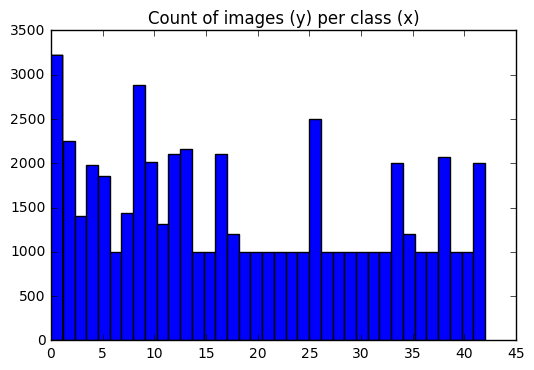

Description: Children crossing


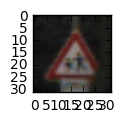

In [5]:
# Give a count of the modified training data
# show a histogram for human readibility
print("Total item count =", n_train)
plt.hist(y_train, bins='auto')
plt.title("Count of images (y) per class (x)")
plt.show()

index = random.randint(0, len(extension_to_X_train))
image = extension_to_X_train[index]

plt.figure(figsize=(1,1))
plt.imshow(image)
print("Description: " + labelmap[extension_to_y_train[index]])


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_



**Answer:**

Done grayscaling, rendering an example output vs the original:
Index:  45324
Description: Road narrows on the right


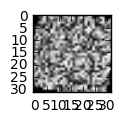

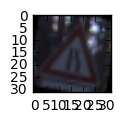

In [17]:
import cv2

#X_train_grayscale = []
#for index in range(n_train):
#    grayscale = cv2.cvtColor(X_train_scaled[index], cv2.COLOR_BGR2GRAY)
#    X_train_grayscale.append(grayscale)
X_train_grayscale = []
for index in range(n_train):
    grayscale = np.zeros_like(img, dtype=np.float32)
    rgb = X_train[index]
    y = 0.2989 * rgb[:,:,0] + 0.5870 * rgb[:,:,1] + 0.1140 * rgb[:,:,2]
    grayscale[:,:,0] = grayscale[:,:,1] = grayscale[:,:,2] = y.squeeze()
    X_train_grayscale.append(grayscale)


print("Done grayscaling, rendering an example output vs the original:")

index = random.randint(0, n_train)
print("Index: ", index)
image = X_train_grayscale[index]

plt.figure(figsize=(1,1))
plt.imshow(image)
plt.figure(figsize=(1,1))
plt.imshow(X_train[index])
print("Description: " + labelmap[y_train[index]])

# we now have a second set of images which is the same as the cropped-resized images we pre-processed before
# but in a human-balanced grayscale, still 3 channels.


In [18]:
# Normalize the data first (centered at 0,0, with a span of 1)
# We know the RGB data is supposed to be 0 to 255

def normalize_rgb_value(val):
    #print(val)
    #print(val.shape)
    return (val - 128) / 128

def normalize_image(image):
    return (image - 128) / 128

def normalize_image2(image):
    normalized = np.zeros(image_shape, dtype=np.float32)
    if (len(image.shape) > 2):
        value_0 = image[:,:,0]
        value_1 = image[:,:,1]
        value_2 = image[:,:,2]
    else:
        value_0 = value_1 = value_2 = image[:,:]
    normalized[:,:,0] = normalize_rgb_value(value_0)
    normalized[:,:,1] = normalize_rgb_value(value_1)
    normalized[:,:,2] = normalize_rgb_value(value_2)
    return normalized

X_train_grayscale_normalized = np.array([normalize_image(i) for i in X_train_grayscale])
X_train_normalized = np.array([normalize_image(i) for i in X_train.astype(np.float32)])
X_test_normalized = np.array([normalize_image(i) for i in X_test.astype(np.float32)])


Index:  45324


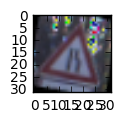

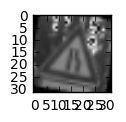

In [19]:
#index = random.randint(0, n_train)
print("Index: ", index)
plt.figure(figsize=(1,1))
plt.imshow(X_train_normalized[index])
plt.figure(figsize=(1,1))
plt.imshow(X_train_grayscale_normalized[index])


Done splitting and shuffling items
87254
22166
Description: Turn right ahead


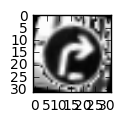

In [20]:
# Let's say we want 80% of the data to be testing data, and 20% to be validation data
# We also want to shuffle the items in the testing set and the validation set
from sklearn.utils import shuffle

train_split_prob = 0.8
X_train_split = []
y_train_split = []
X_validation_split = []
y_validation_split = []
def split_and_append(Xinput, yinput, split_prob, X1, y1, X2, y2):
    """
    Takes the input X,y and appends them to X1,y1 or X2,y2 depending
    on the split_prob value.
    """
    for index in range(len(Xinput)):
        image = Xinput[index]
        classification = yinput[index]
        is_second_split = random.random() >= split_prob
        if is_second_split:
            X2.append(image)
            y2.append(classification)
        else:
            X1.append(image)
            y1.append(classification)

split_and_append(X_train_normalized,
                 y_train,
                 train_split_prob,
                 X_train_split,
                 y_train_split,
                 X_validation_split,
                 y_validation_split)
split_and_append(X_train_grayscale_normalized,
                 y_train,
                 train_split_prob,
                 X_train_split,
                 y_train_split,
                 X_validation_split,
                 y_validation_split)

X_train_split, y_train_split = shuffle(X_train_split, y_train_split)
X_validation_split, y_validation_split = shuffle(X_validation_split, y_validation_split)


print("Done splitting and shuffling items")
expected_len_X = len(X_train_normalized) + len(X_train_grayscale_normalized)
expected_len_y = len(y_train) * 2
len_train_X = len(X_train_split)
len_validation_X = len(X_validation_split)
len_train_y = len(y_train_split)
len_valudation_y = len(y_validation_split)
assert expected_len_X == len_train_X + len_validation_X
assert expected_len_y == len_train_y + len_valudation_y
assert len_train_X == len_train_y
assert len_validation_X == len_valudation_y
print(len_train_X)
print(len_validation_X)

index = random.randint(0, n_train)
image = X_train_split[index]

plt.figure(figsize=(1,1))
plt.imshow(image)
print("Description: " + labelmap[y_train_split[index]])

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Splitting the training set**

We already had one training set and one test set to begin with. I'm leaving the test set as is and intend to use it only once after I'm fully confident of the accuracy of my model based on the test data.

The training set, however, is going to be split in 2 parts:
  - 80% of the data into the actual training set
  - 20% of the data into a new validation set

This partition is achieved by iterating on the input data set (X,y) and splitting it into the 2 buckets (training(X,y) and validation(X,y)). Each data pair (Xi,yi) is assigned to a set by obtaining a random number between 0.0 and 1.0 and choosing one bucket if the random number is below the threshold, or the other bucket if it's above the threshold. This makes it easy to think of partitioning the data as percentages of the input. Note that here we assume that the random number generator gives a relatively uniform distribution of results over the [0.0, 1.0] continuum.

After the training set and validation set have been created, we proceed to shuffle their contents by 


**Newly generated data**

I read that the picked data contained cropping information, encoded as the 4 corners of a square in the original image size map. I transformed the cropping information to the coordinate system used by the scaled image (32 x 32) used a PIL image to first crop the area outside the pixels of interest. Since our algorithm assumes a 32 x 32 image, I scaled the image back to the specified dimensions.

I chose this in order to reduce the signal-to-noise ratio of the data we're sending to the network. I'm assuming that the pixels outside of the area of interest are noise and might lower the overall accuracy of our predictions. For example, if all the training images had green or brown from trees in the background, the network might fail to understand that a sign with a blue-sky in the background is equally valid. Furthermore, if we move this to grayscale, the elimination of the surrounding pixels is just as useful. Imagine that for a specific type of traffic sign, such as "yield", we didn't have enough training data. In that case our network will be very sensitive to all the pixels available in the few images we have. This might mean that our network can only recognize "yield" signs when the signal and the noise levels of the test data are similar to those of the training data. I'm assuming that by reducing the noise in the training data we render the noise in the test data less detrimental overall.

My assumptions might be wrong, so not only will I be training my network, I'll be training my own personal experience and the heuristics I'll use going forward.

I decided to take this step to generate grayscale images corresponding to the scaled images. We really have 3 data sets at this point:
  - The original images
  - The scaled images (scaled using the provided data)
  - The grayscale images from the scaled images

The three data sets can use the same y_train array as the order and type of the items is preserved in the 2 derived sets. I intend to only use the scaled images, both grayscale and color, and leave the original images out for now.

I'm thinking perhaps training the data on both the color and the grayscale images might help me improve the accuracy of the predictions going forward. I'll try to ensure that the network can decide "this is a yield sign" based on the unique characteristics found in the color image, or the more general strokes seen in the grayscale image.

I originally though of taking the original images and tilt them by a random amount of degrees, ranging from -20 to 20 degrees or so. I decided not to do this on my first try because my intuition tells me this might not help me improve the model any more than additional epochs will. Basically, I'm assuming two things:
  - There should be enough data variety in the training set to more naturally express real-world data
  - The convolution processes I'll apply going forward will dramatically transform the data, to the point where tilts in the image might not matter
  
The second point in particular is pure intuition and I will eventually test whether this is true or not. 

**Answer:**

In [21]:
def LeNet(x, keep_probability):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    # new_height = (input_height - filter_height + 2 * P)/S + 1
    # 28 = ((32 - fh)/S) + 1
    #(27 * S) + fh= 32
    # S = 1, fh = 5    
    F_W = tf.Variable(tf.truncated_normal((5, 5, 3, 6), mean = mu, stddev = sigma, dtype=tf.float32))
    F_b = tf.Variable(tf.zeros(6))
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    layer1 = tf.nn.conv2d(x, F_W, strides, padding) + F_b

    # Activation.
    layer1 = tf.nn.relu(layer1)
    
    # Dropout
    layer1 = tf.nn.dropout(layer1, keep_probability)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    # new_height = (input_height - filter_height)/S + 1
    # 14 = ((28 - fh)/S) + 1
    # (13 * S) + fh = 28
    # S = 2, fh = 2
    ksize=[1, 2, 2, 1]
    strides=[1, 2, 2, 1]
    padding = 'VALID'
    pooling_layer1 = tf.nn.max_pool(layer1, ksize, strides, padding)
    
    # Layer 2a: Convolutional. Input = 28x28x6. Output = 5x5x16.
    # new_height = (input_height - filter_height + 2 * P)/S + 1
    # 5 = ((28 - fh)/S) + 1
    # (4 * S) + fh = 28
    # S = 2, fh = 20
    F_W = tf.Variable(tf.truncated_normal((20, 20, 6, 16), mean = mu, stddev = sigma, dtype=tf.float32))
    F_b = tf.Variable(tf.zeros(16))
    strides = [1, 2, 2, 1]
    padding = 'VALID'
    layer2a = tf.nn.conv2d(layer1, F_W, strides, padding) + F_b
    
    # Flatten. Input = 1x1x400. Output = 400.
    flatten_layer2a = tf.contrib.layers.flatten(layer2a)

    # Layer 2b: Convolutional. Output = 10x10x16.
    # new_height = (input_height - filter_height + 2 * P)/S + 1
    # 10 = ((14 - fh)/S) + 1
    # (9 * S) + fh = 14
    # S = 1, fh = 5
    F_W = tf.Variable(tf.truncated_normal((5, 5, 6, 16), mean = mu, stddev = sigma, dtype=tf.float32))
    F_b = tf.Variable(tf.zeros(16))
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    layer2b = tf.nn.conv2d(pooling_layer1, F_W, strides, padding) + F_b
    
    # Activation.
    layer2b = tf.nn.relu(layer2b)
    
    # Dropout
    layer2b = tf.nn.dropout(layer2b, keep_probability)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    # new_height = (input_height - filter_height)/S + 1
    # 5 = ((10 - fh)/S) + 1
    # (4 * S) + fh = 10
    # S = 2, fh = 2
    ksize=[1, 2, 2, 1]
    strides=[1, 2, 2, 1]
    padding = 'VALID'
    pooling_layer2b = tf.nn.max_pool(layer2b, ksize, strides, padding)

    # Flatten. Input = 5x5x16. Output = 400.
    flatten_layer2b = tf.contrib.layers.flatten(pooling_layer2b)
    
    # Concat layer 2a and layer 2b
    flat_layer2 = tf.concat_v2([flatten_layer2b, flatten_layer2a], 1)
    
    # Layer 3: Fully Connected. Input = 800. Output = 120.
    F_W = tf.Variable(tf.truncated_normal((800, 120), mean = mu, stddev = sigma, dtype=tf.float32))
    F_b = tf.Variable(tf.zeros(120))
    fully_connected = tf.matmul(flat_layer2, F_W) + F_b
    
    # Activation.
    fully_connected = tf.nn.relu(fully_connected)
    
    # Dropout
    fully_connected = tf.nn.dropout(fully_connected, keep_probability)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    F_W = tf.Variable(tf.truncated_normal((120, 84), mean = mu, stddev = sigma, dtype=tf.float32))
    F_b = tf.Variable(tf.zeros(84))
    fully_connected = tf.matmul(fully_connected, F_W) + F_b
    
    # Activation.
    fully_connected = tf.nn.relu(fully_connected)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    F_W = tf.Variable(tf.truncated_normal((84, n_classes), mean = mu, stddev = sigma, dtype=tf.float32))
    F_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fully_connected, F_W) + F_b
    
    return logits


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [22]:
import tensorflow as tf

# Let's initialize the model
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_probability = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

adam_learning_rate = 0.0001
#gradient_descent_learning_rate = 0.1

logits = LeNet(x, keep_probability)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
#prediction = tf.nn.softmax(logits)
#cross_entropy = -tf.reduce_sum(y * tf.log(prediction), reduction_indices=1)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(adam_learning_rate)
#optimizer = tf.train.GradientDescentOptimizer(gradient_descent_learning_rate)
training_operation = optimizer.minimize(loss_operation)


In [23]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [24]:
EPOCHS = 100
BATCH_SIZE = 2048


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_probability: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_split)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_split, y_train_split = shuffle(X_train_split, y_train_split)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_split[offset:end], y_train_split[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_probability: 1.0})
            
        validation_accuracy = evaluate(X_validation_split, y_validation_split)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.087

EPOCH 2 ...
Validation Accuracy = 0.217

EPOCH 3 ...
Validation Accuracy = 0.370

EPOCH 4 ...
Validation Accuracy = 0.516

EPOCH 5 ...
Validation Accuracy = 0.614

EPOCH 6 ...
Validation Accuracy = 0.688

EPOCH 7 ...
Validation Accuracy = 0.734

EPOCH 8 ...
Validation Accuracy = 0.770

EPOCH 9 ...
Validation Accuracy = 0.803

EPOCH 10 ...
Validation Accuracy = 0.823

EPOCH 11 ...
Validation Accuracy = 0.842

EPOCH 12 ...
Validation Accuracy = 0.853

EPOCH 13 ...
Validation Accuracy = 0.865

EPOCH 14 ...
Validation Accuracy = 0.877

EPOCH 15 ...
Validation Accuracy = 0.883

EPOCH 16 ...
Validation Accuracy = 0.890

EPOCH 17 ...
Validation Accuracy = 0.892

EPOCH 18 ...
Validation Accuracy = 0.901

EPOCH 19 ...
Validation Accuracy = 0.904

EPOCH 20 ...
Validation Accuracy = 0.909

EPOCH 21 ...
Validation Accuracy = 0.912

EPOCH 22 ...
Validation Accuracy = 0.914

EPOCH 23 ...
Validation Accuracy = 0.918

EPOCH 24 ...
Validation Accura

In [25]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.877


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.